In [48]:
%matplotlib inline
import glob
import os
import librosa
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from data_aws.upload_data import upload, delete_dirs
import librosa.display
#### extract featurse from 
from helpers.features import * 
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json

In [49]:
# load json and create model
json_file = open('cnn_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("model.weights.best_cnn.hdf5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 60, 100, 16)       176       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 20, 16)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 20, 16)        64        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 20, 32)        5152      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 4, 32)         0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 15, 4, 32)         128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 4, 64)         20544     
__________

In [50]:
#### get features from urban8k dataset ####

tr_features = np.load('cnn_tr_features.npy')
tr_labels = np.load('cnn_tr_labels.npy')
test_features = tr_features[10000:]
test_labels = tr_labels[10000:]

In [51]:
##### Sound Classes
sound_names = ["air conditioner",
               "car horn",
               "children playing",
                "dog bark",
               "drilling",
               "engine idling", 
               "gun shot",
                "jackhammer",
               "siren",
               "street music"]

In [52]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

In [53]:
# evaluate and print test accuracy
score = model.evaluate(tr_features[10000:], tr_labels[10000:], verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.96552690583


Showing Confusion Matrix


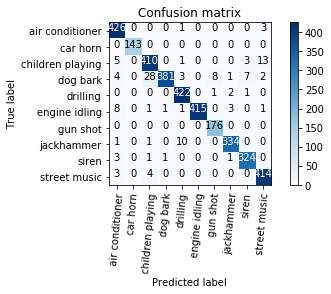

In [54]:
### TODO reserve logic for training and test dataset ######
import itertools
from sklearn.metrics import confusion_matrix
import pylab as pl
print( "Showing Confusion Matrix")
y_prob = predictions = model.predict(test_features)
y_predictions = np.argmax(predictions,axis=1)
# y_pred = np_utils.probas.argmax(axis=-1)(y_prob)
y_true = np.argmax(test_labels, 1)
cm = confusion_matrix(y_true, y_predictions)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=85)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
        pass
#         print('Confusion matrix, without normalization')

   

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_predictions)
    np.set_printoptions(precision=2)


    plt.figure()

    plt.show()
plot_confusion_matrix(cm, classes=sound_names,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

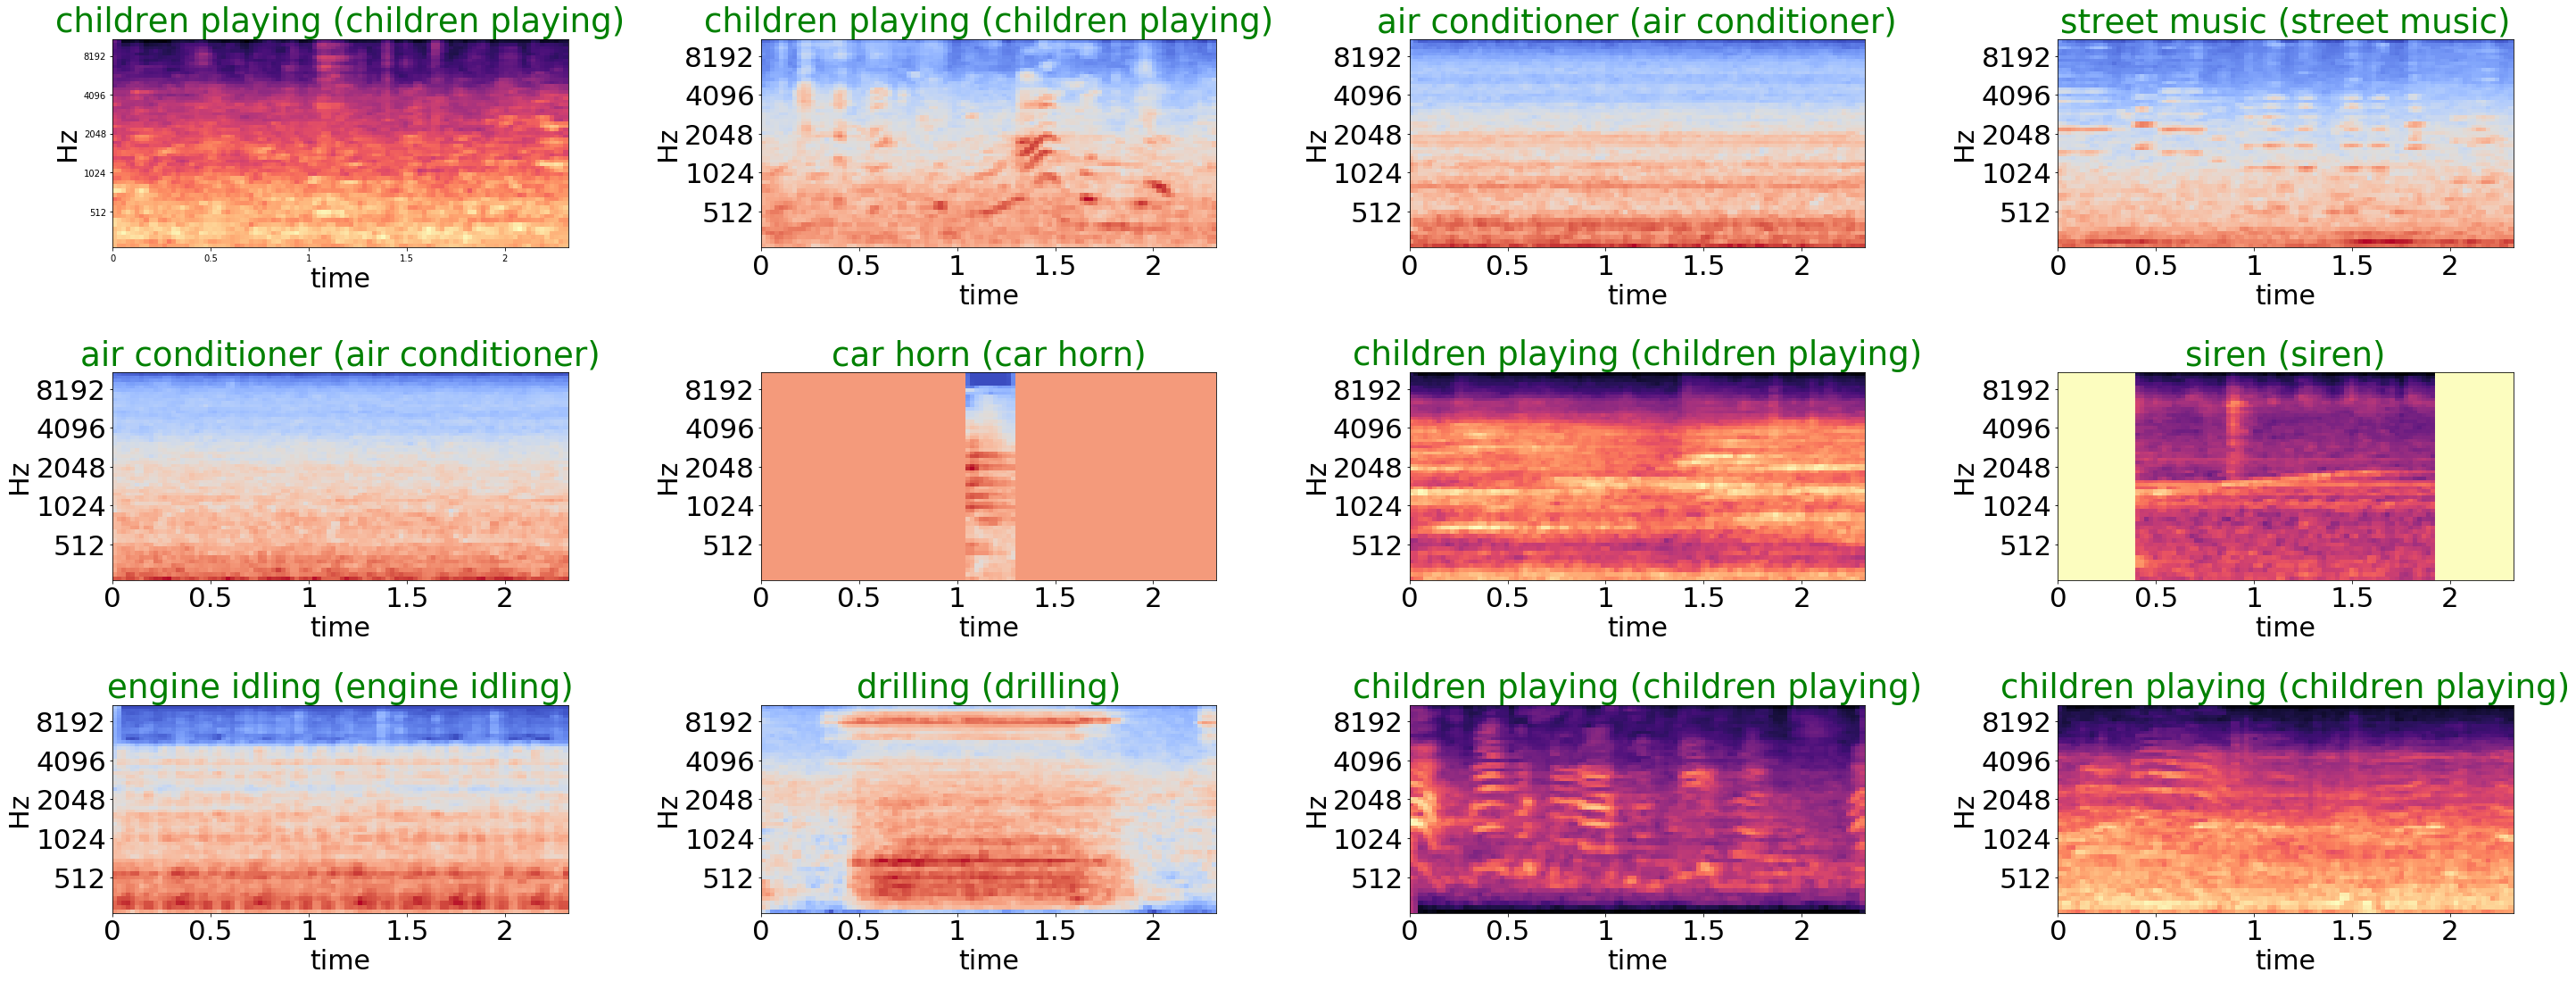

In [55]:
# plot a random sample of test images, their predicted labels, and ground truth

##TODO replace with actual test data from test file ####
test_features, test_y = tr_features[13000:13026], tr_labels[13000:13026]
test_labels = [sound_names[i] for i in np.argmax(test_y,axis=1)]
predictions = model.predict(tr_features[13000:13026])
predictions = np.argmax(predictions,axis=1)
predictions = np.eye(10)[predictions]

prediction_labels = [sound_names[i] for i in np.argmax(predictions,axis=1)]
fig = plt.figure(figsize=(40, 16))
for i, idx in enumerate(np.random.choice(test_features.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    librosa.display.specshow(test_features[idx,:,:,0], x_axis='time', y_axis='mel')
    plt.xlabel('time', fontsize=30)
    plt.ylabel('Hz', fontsize=30)
    font = {"size":31}
    plt.rc('font', **font)
    pred_idx = test_labels[idx]
    true_idx = prediction_labels[idx]
    plt.tight_layout()
    ax.set_title("{} ({})".format(pred_idx, true_idx),
                  color=("green" if pred_idx == true_idx else "red"), y=1.01,)
 


In [57]:
youtube_sound,youtube_y_raw,fn = parse_audio_files('data',['my_data'])
youtube_y = one_hot_encode(youtube_y_raw)

score = model.evaluate(youtube_sound,y=youtube_y)
print('Number of files: ', len(fn))
print('\n', 'Accuracy on YouTube:', score[1])
correct_f=[]
incorrect_f=[]
youtube_predictions = []
for s in range(youtube_sound.shape[0]):
    # generate prediction, passing in just a single row of features
    predictions = model.predict(youtube_sound[s].reshape(1,60,100,1))

    if len(predictions) == 0: 
        print( "No prediction")
        continue
    correct = sound_names[youtube_y_raw[s]] 
    ind = np.argpartition(predictions[0], -2)[-2:]
    ind[np.argsort(predictions[0][ind])]
    ind = ind[::-1]
    youtube_predictions.append(ind[0])
    if correct == sound_names[ind[0]]:
        correct_f.append((correct,fn[s]))
    else:
        incorrect_f.append((sound_names[ind[0]],fn[s]))

    print("Correct Value: ", correct )
    print("Top guess: ", sound_names[ind[0]], " (",round(predictions[0,ind[0]],3),")")
    print("2nd guess: ", sound_names[ind[1]], " (",round(predictions[0,ind[1]],3),")")
    print()


18/18 [==============================] - 0s
Number of files:  18

 Accuracy on YouTube: 0.611111104488


NameError: name 'indx' is not defined

In [ ]:
import IPython

print("Correct Result: ",correct_f[0][0])
IPython.display.Audio(correct_f[0][1])

In [ ]:
import IPython

print("Correct Result: ",correct_f[4][0])
IPython.display.Audio(correct_f[4][1])

In [ ]:
import IPython
i_index = 4
print(incorrect_f[i_index][1])
print("Incorrect Result: ",incorrect_f[i_index][0])
IPython.display.Audio(incorrect_f[i_index][1])

In [ ]:
import IPython
i_index = 5
print(incorrect_f[i_index][1])
print("Incorrect Result: ",incorrect_f[i_index][0])
IPython.display.Audio(incorrect_f[i_index][1])

In [ ]:
fig = plt.figure(figsize=(40, 16))
for i, idx in enumerate(np.random.choice(youtube_sound.shape[0], size=12, replace=False)):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    librosa.display.specshow(youtube_sound[idx,:,:,0], x_axis='time', y_axis='mel')
    plt.xlabel('time', fontsize=30)
    plt.ylabel('Hz', fontsize=30)
    font = {"size":31}
    plt.rc('font', **font)
    pred_idx = sound_names[youtube_predictions[idx]]
    true_idx = sound_names[youtube_y_raw[idx]]
    plt.tight_layout()
    ax.set_title("{} ({})".format(pred_idx, true_idx),
                  color=("green" if pred_idx == true_idx else "red"), y=1.01,)